# Opera DL Knowledge Transfer

## Intro

The aim of this experiment is to evaluate the performance of a DL model designed for the Univer PV system (University of Jaen, Spain) when applied to a different context.
Using Google Dataset search we have found a good dataset to run this experiment: a PV power production dataset from the SolarTech Lab (Politecnico di Milano, Italy), as described below.

On a first review, the dataset from the SolarTech Lab doesnt include the temperature of the module as a parameter, which had been used in the Univer PV nowcasting experiment, so we will re-define the model to use the common parameters between the two contexts:

Input: Ambient Temperture, Irradiation

Output: PV Power

## SolarTech Lab dataset

SolarTech Lab dataset additional information (https://ieee-dataport.org/open-access/photovoltaic-power-and-weather-parameters): 

This dataset includes PV power production measured on the SolarTech Lab, Politecnico di Milano, Italy. Data are freely available for scientific research purpose and further data validation.

In particular, the dataset is composed of the following variables and specifics, with a time resolution of 1 minute:

Timestamp: column with time recordings; the data format is “dd-MM-yyyy hh:mm:ss”, with the time always expressed in Central European Time (CET).
Pm: power recordings from the PV module (W); module tilt: 30°.
Tair: ambient temperature (°C) measured by the weather station described in SolarTech Lab website (http://www.solartech.polimi.it/instrumentation/).
GHI: measured Global Horizontal Irradiance (W/m2).
GPOA: global irradiance measured on the plane of array (30°).
Ws: measured wind speed (m/s).
Wd: measured wind direction (°), assuming 0° east, positive south.

It is worth noticing that this dataset includes original measurements, i.e. these raw data can be used for any additional post-processing, validation and further research. When a value is missing in the original measurements recording, a “NaN” is reported.



## Experiment
### 0. Environment configuration

In [2]:
!pip install tensorflow
!pip install keras
!pip install scikeras
!pip install matplotlib
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
#from scikeras.wrappers import KerasRegressor
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_predict
from keras.models import Sequential
from keras.layers import Conv1D, Dropout, LSTM, Dense, Activation
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from tensorflow import keras

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
  Using cached tensorflow-2.7.0-cp37-cp37m-manylinux2010_x86_64.whl (489.6 MB)
  Using cached flatbuffers-2.0-py2.py3-none-any.whl (26 kB)
  Using cached Keras_Preprocessing-1.1.2-py2.py3-none-any.whl (42 kB)
  Using cached termcolor-1.1.0-py3-none-any.whl
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached absl_py-1.0.0-py3-none-any.whl (126 kB)
  Using cached libclang-12.0.0-py2.py3-none-manylinux1_x86_64.whl (13.4 MB)
  Using cached gast-0.4.0-py3-none-any.whl (9.8 kB)
  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
  Using cached tensorboard-2.7.0-p

### 1. Overview and pre-process the SolarTech Lab dataset
#### Describe dataset and extract parameters

We are going to extracts the input parameters Time, T_air and G_tilt and the output PV_Power.

** Pre-processing activities **

We are going to use two months of data only.


The value of PV_Power is NaN when the system is not generating any power, this can be for two reasons:
- Failure of the PV system: for these scenarios, we will remove the data of a full day (24 hours period) when the number of NaN values for that day is greater than 80% (threshold TBC).
- When there is no irradation so the system is actually not generating any power: we will replace NaN with 0 (zero).

For all the  parameters, we will downsample the dataset to 10 minutes using the average, this will get rid of 

- There are temperatures of -999999.000000, we will replace any temperature below -100 degress with NaN so they are not included in the average calculation.

- The max power of the system seems to be around 200W, abut there some values of >1000. We will replace any power above 400W  with NaN so they are not included in the average calculation



Any remain NaN values after downsampling will be interpolated.


In [3]:
df_raw = pd.read_csv('Dataset-SolarTechLab.csv',delimiter=';',parse_dates=['Time']).set_index('Time')
#df_raw = pd.read_csv('Dataset-SolarTechLab.csv',delimiter=';',parse_dates=['Time'])
df_raw=df_raw['2017-06-09':'2017-11-23']
df_raw.describe()

,PV_Power,T_air,G_h,G_tilt,W_s,W_d
count,94278.000000,239046.000000,239046.000000,239046.000000,239046.000000,239046.00000
mean,103.502622,-138.716559,198.282544,218.901128,1.338481,184.47742
std,654.318790,12607.409858,281.541105,316.206175,1.161411,105.36151
min,0.612183,-999999.000000,0.000000,0.000000,0.000000,0.00000
25%,25.032757,14.690000,0.000000,0.000000,0.470000,79.00000
50%,89.577591,21.030000,16.000000,15.000000,1.060000,216.80000
75%,160.048580,25.730000,354.000000,389.000000,1.910000,267.30000
max,53302.005859,37.410000,1312.000000,1388.000000,15.010000,359.00000


Let's identify and pre-process outliers or corrupted values:
- 20 values of PV_Power above 1000W
- 52 values of T_air under -100

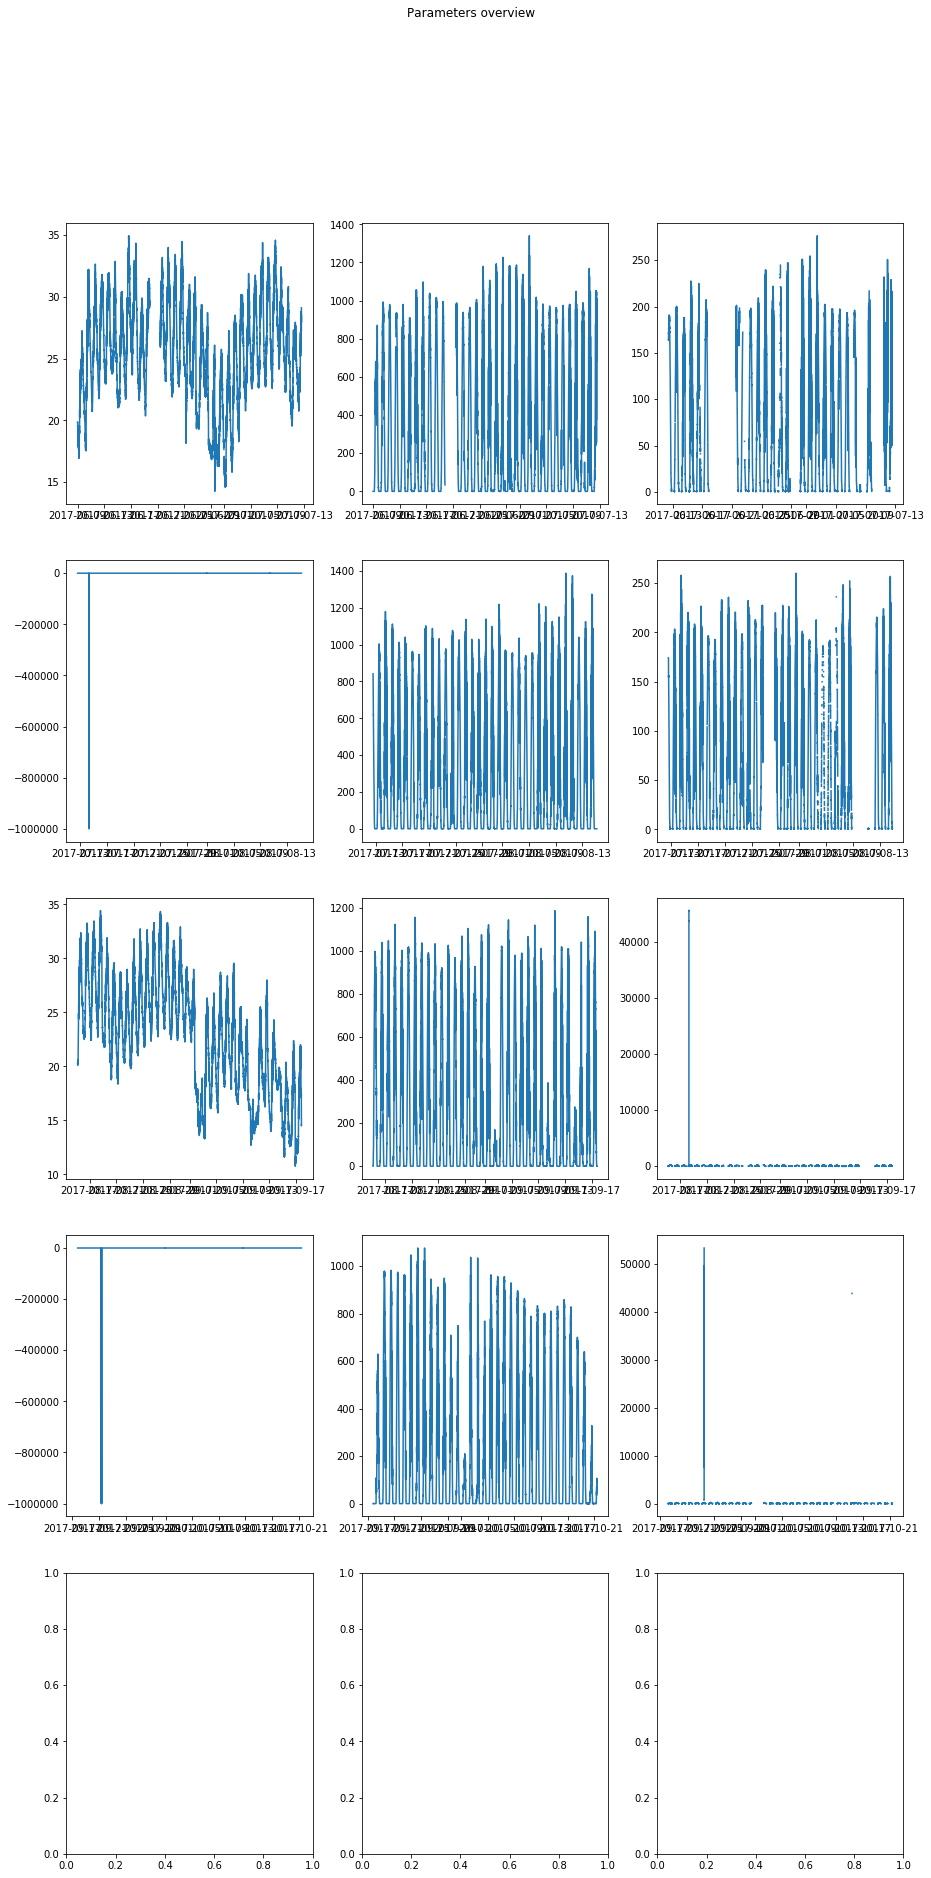

In [4]:
columns=['T_air', 'G_tilt', 'PV_Power']
# Please change this list of months asap
n_charts=5
interval=int((len(df_raw.index)/n_charts))

fig, axs = plt.subplots(n_charts,len(columns))
fig.suptitle('Parameters overview')
fig.set_figheight(30)
fig.set_figwidth(15)


for i,m in enumerate(range(1,n_charts)):
    for j,val in enumerate(columns):
        axs[i,j].plot(df_raw[val][(m*interval)-interval:m*interval])
        #axs[i,j].set_title(val + m)

In [5]:
df_raw.loc[df_raw['PV_Power'] > 400].count()

PV_Power    24
T_air       24
G_h         24
G_tilt      24
W_s         24
W_d         24
dtype: int64

In [6]:
df_raw.loc[df_raw['T_air'] < -100].count()

PV_Power    37
T_air       38
G_h         38
G_tilt      38
W_s         38
W_d         38
dtype: int64

Let's change the outliers for NaN values, resample to 10 minutes using the average and have a look at the charts again.

In [7]:
df_p=df_raw
df_p['PV_Power'] = np.where(df_p['PV_Power'] > 400, np.nan, df_p['PV_Power'])
df_p['T_air'] = np.where(df_p['T_air'] < -100, np.nan, df_p['T_air'])
df_10min=df_p.resample('10T').mean()

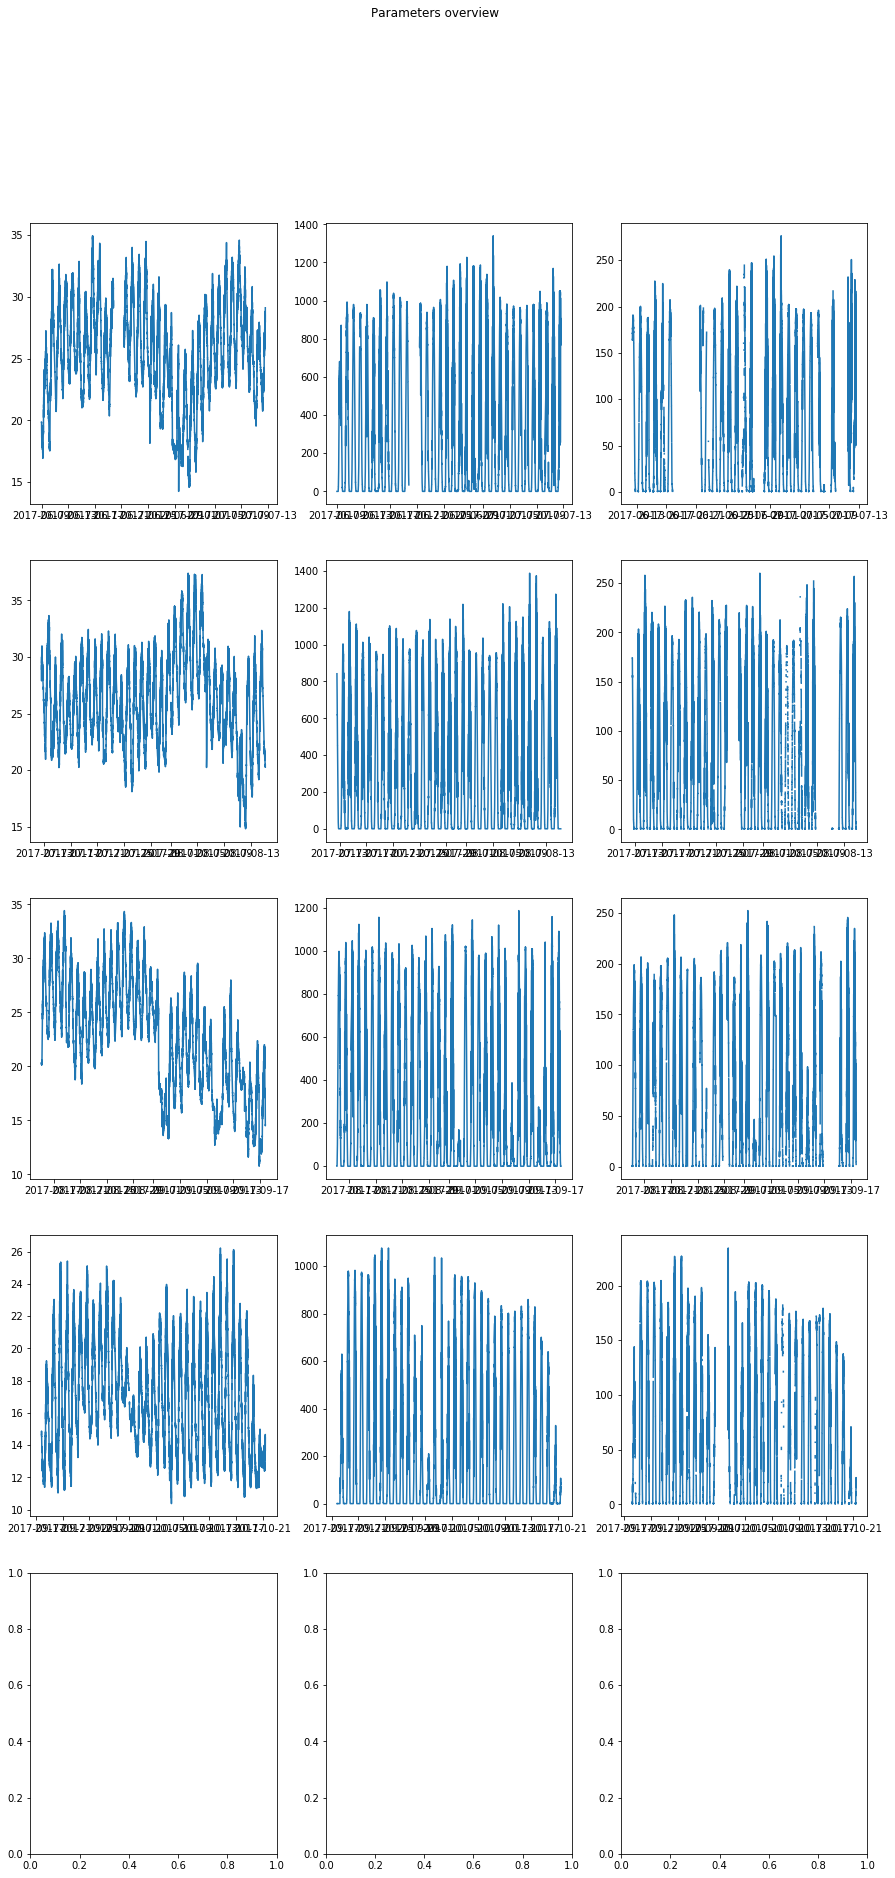

In [8]:
columns=['T_air', 'G_tilt', 'PV_Power']
n_charts=5
interval=int((len(df_raw.index)/n_charts))

fig, axs = plt.subplots(n_charts,len(columns))
fig.suptitle('Parameters overview')
fig.set_figheight(30)
fig.set_figwidth(15)


for i,m in enumerate(range(1,n_charts)):
    for j,val in enumerate(columns):
        axs[i,j].plot(df_raw[val][(m*interval)-interval:m*interval])

Let's remove days where PV_Power=NaN with G > 40 is greater than 10% of the values. Then pad values of PV_Power and interpolate any remaining NaN values in the other parameters T_air, G_tilt

In [9]:
df_10min=df_10min.reset_index()

In [10]:
num_threshold = (24*60/10)*0.9
g_threshold = 40
p_threshold = 0.9

df_10min['ValidValue'] = df_10min['G_tilt'].lt(g_threshold) | df_10min['PV_Power'].gt(p_threshold)

df_10min['CountValidValues'] = df_10min.groupby(pd.Grouper(key='Time',freq='D')).ValidValue.transform('sum').astype(float)

df=df_10min[df_10min['CountValidValues']>num_threshold]

df=df.reset_index(drop=True)


In [11]:
df.describe()

,PV_Power,T_air,G_h,G_tilt,W_s,W_d,CountValidValues
count,9154.000000,17107.000000,17108.000000,17108.000000,17108.000000,17108.000000,17136.000000
mean,90.819421,20.663879,205.678344,228.461874,1.331969,183.051082,143.344538
std,68.554769,6.913359,282.348556,319.369878,0.959737,75.082839,2.367342
min,0.635376,2.900000,0.000000,0.000000,0.000000,3.420000,130.000000
25%,20.778251,15.303000,0.000000,0.000000,0.549750,116.827500,144.000000
50%,86.875247,21.512000,18.800000,17.450000,1.187000,199.045000,144.000000
75%,155.374256,26.082500,385.550000,437.200000,1.924000,246.530000,144.000000
max,242.677303,36.723000,1050.900000,1103.200000,7.360000,340.140000,144.000000


In [12]:
df.isna().sum()

Time                   0
PV_Power            7982
T_air                 29
G_h                   28
G_tilt                28
W_s                   28
W_d                   28
ValidValue             0
CountValidValues       0
dtype: int64

In [13]:
df['PV_Power'] = np.where(df['G_tilt'] == 0, 0, df['PV_Power'])
df['PV_Power']=df['PV_Power'].interpolate()
df=df.interpolate()
df

,Time,PV_Power,T_air,G_h,G_tilt,W_s,W_d,ValidValue,CountValidValues
0,2017-06-13 00:00:00,0.0,24.851,0.0,0.0,1.168,257.03,True,144.0
1,2017-06-13 00:10:00,0.0,24.802,0.0,0.0,1.375,285.66,True,144.0
2,2017-06-13 00:20:00,0.0,24.758,0.0,0.0,0.996,260.49,True,144.0
3,2017-06-13 00:30:00,0.0,24.767,0.0,0.0,1.010,272.68,True,144.0
4,2017-06-13 00:40:00,0.0,24.682,0.0,0.0,0.603,280.12,True,144.0
...,...,...,...,...,...,...,...,...,...
17131,2017-11-21 23:10:00,0.0,8.200,0.0,0.0,1.187,80.12,True,144.0
17132,2017-11-21 23:20:00,0.0,8.055,0.0,0.0,1.278,61.68,True,144.0
17133,2017-11-21 23:30:00,0.0,7.949,0.0,0.0,1.354,68.18,True,144.0
17134,2017-11-21 23:40:00,0.0,7.861,0.0,0.0,1.661,68.62,True,144.0


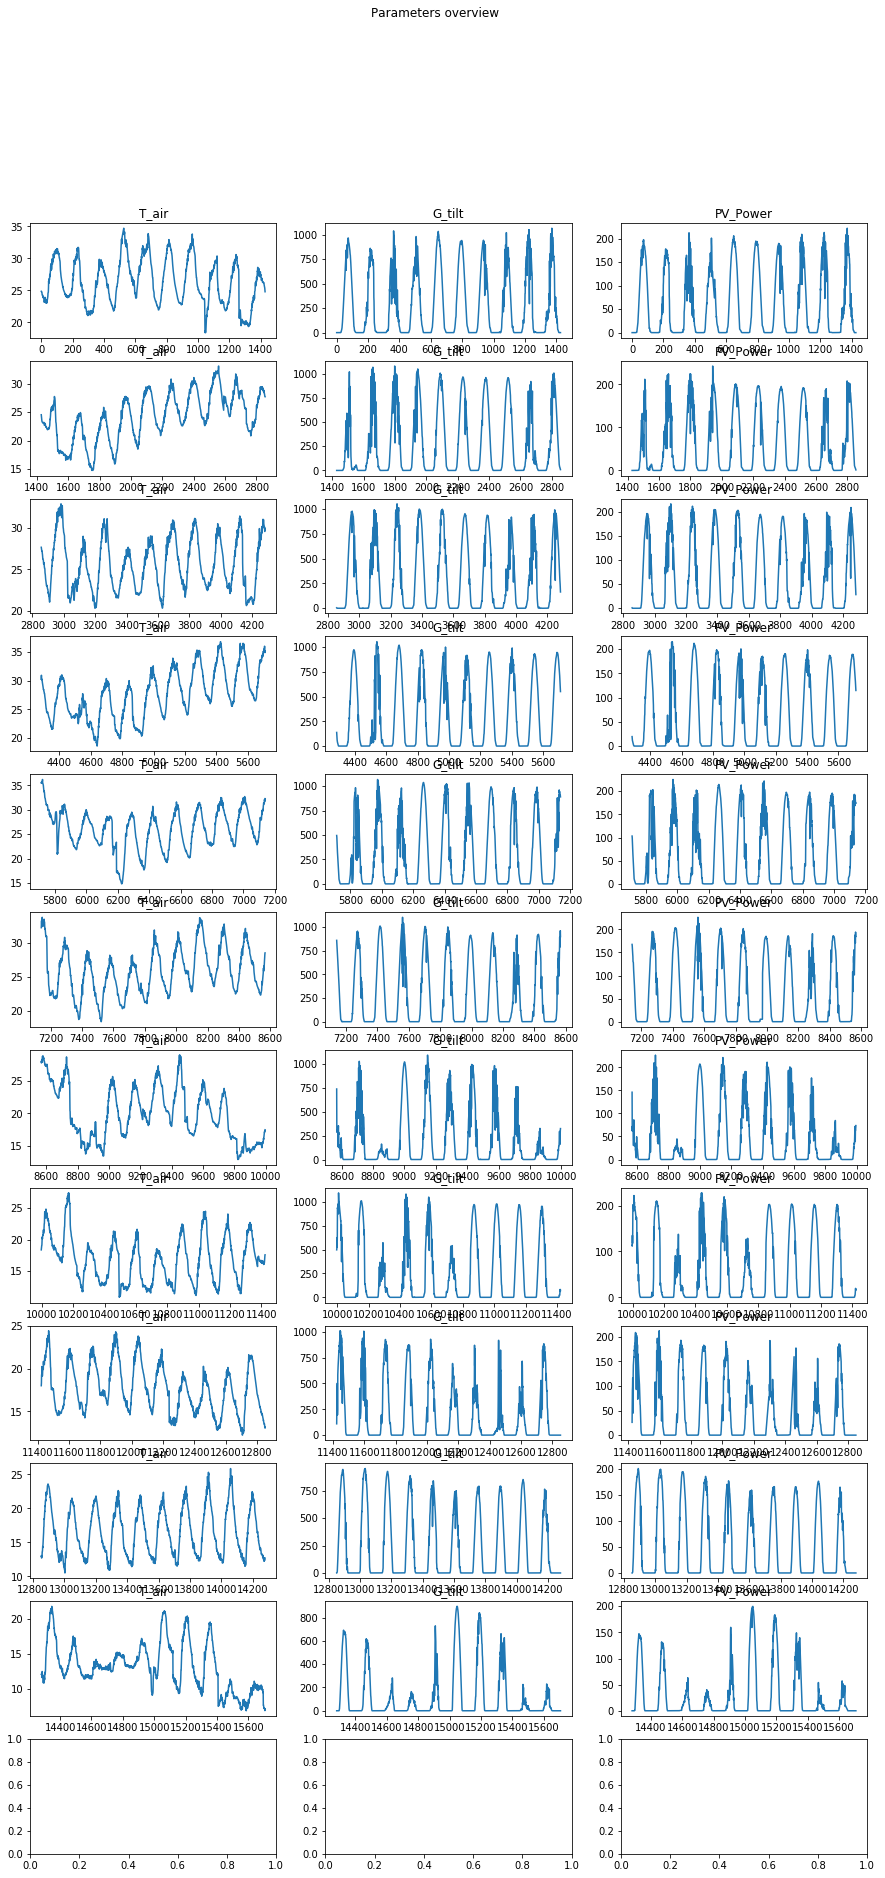

In [14]:
columns=['T_air', 'G_tilt', 'PV_Power']
interval=(df['PV_Power'].count()/12).astype(int)
fig, axs = plt.subplots(12,len(columns))
fig.suptitle('Parameters overview')
fig.set_figheight(30)
fig.set_figwidth(15)


for i,m in enumerate(range(1, 12)):
    for j,val in enumerate(columns):
        axs[i,j].plot(df[val][(m*interval)-interval:m*interval])
        axs[i,j].set_title(val)
        #print(i,j,m*interval)
    

### 2. Bare Learning
#### Prepare the dataset

Features: T_air and G_tilt

Output: PV_Power

We will prepare a 90 minutes window (9 samples * 10 minutes) for the training dataset and normalise using a Standard Scaler.
For the evaluation dataset we will use a MinMax Scaler.
We will remove

In [15]:
time_steps = 9
features=['G_tilt','T_air']


df=df.fillna(value=0)

X = np.zeros((len(df), time_steps, len(features)))

for ix in range(time_steps):
  X[:,ix,:] = df[features].shift(ix)

#Drop NaN
X = X[time_steps:]
y = df['PV_Power'][time_steps:]

# Normalise
X_norm=X
scalers_X = {}
for i in range(X.shape[2]):
    scalers_X[i] = StandardScaler()
    X_norm[:, :, i] = scalers_X[i].fit_transform(X[:, :, i]) 

scaler_y = MinMaxScaler()
y_norm = scaler_y.fit_transform(y.values.reshape(-1, 1))

pd.DataFrame(X_norm.reshape(-1, 1)).to_csv("milano_xnorm_5months.csv")
pd.DataFrame(y_norm).to_csv("milano_ynorm_5months.csv")

#### Define the DL model
We will reuse the model designed in this previous work (https://www.mdpi.com/1424-8220/20/15/4224) which has proved to have a very good performance nowcasting PV solar power generation

Almonacid-Olleros, G.; Almonacid, G.; Fernandez-Carrasco, J.I.; Espinilla-Estevez, M.; Medina-Quero, J. A New Architecture Based on IoT and Machine Learning Paradigms in Photovoltaic Systems to Nowcast Output Energy. Sensors 2020, 20, 4224. https://doi.org/10.3390/s20154224



In [16]:
n_epochs = 50
# batch size = 1 week of data
b_size = 1008

def baseline_model():
  # create model
  model = Sequential()
  model.add(Conv1D(16,2,padding='valid',activation='relu',strides=1, input_shape=(X_norm.shape[1], X_norm.shape[2])))
  #model.add(MaxPooling1D(pool_size=2))
  model.add(Conv1D(32,2,padding='valid',activation='relu',strides=1))
  #model.add(MaxPooling1D(pool_size=2))
  model.add(Conv1D(64,2,padding='valid',activation='relu',strides=1))
  #model.add(MaxPooling1D(pool_size=2))
  model.add(Dropout(0.25))
  model.add(LSTM(32, return_sequences=True))
  model.add(Dropout(0.25))
  model.add(LSTM(32))
  model.add(Dropout(0.25))
  model.add(Dense(1))
  model.add(Activation('relu'))
  # Compile model
  #model.compile(loss='mae', optimizer=Adam(lr=0.0003), metrics=['mae'])
  #model.compile(loss='mean_squared_error', optimizer='adam')
  model.compile(loss='mean_squared_error', optimizer=Adam(lr=0.0003), metrics=['mean_squared_error','mean_absolute_error'])
  return model

opera_estimator = KerasRegressor(build_fn=baseline_model, epochs=n_epochs, batch_size=b_size, verbose=0)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:27: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.


In [40]:
opera_estimator.fit(X_norm, y_norm)
opera_estimator.model.save('SolarTechEstimator20211209.h5')

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


#### Bare Learning
Evaluate the model

In [56]:
#number of folds ~ number of months
cv_n = 6
scores_predict = cross_val_predict(opera_estimator, X_norm, y_norm, cv=cv_n)
scores_predict_denorm = scaler_y.inverse_transform(scores_predict.reshape(-1, 1))

#pd.DataFrame(scores_predict).to_csv("solartech_prediction_normalised_20211130.csv")
#pd.DataFrame(scores_predict_denorm).to_csv("solartech_prediction_20211130.csv")

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/opt/conda/lib/python3.7/site-packages/keras/

In [57]:
RMSE = np.sqrt(mean_squared_error(y,scores_predict_denorm))
MAE = mean_absolute_error(y,scores_predict_denorm)
R2 = r2_score(y,scores_predict_denorm)
print(RMSE,MAE, R2)

11.53390686545393 5.803814337415399 0.9708300907684887


Results:
- RMSE=18.42W --> 4.64W
- MAE=5.47W --> 2.02W
- R2=0.9197 --> 0.9949

#### Stranger learning

We will try to nowcast the output power generation of the Milano SolarTech Lab system with the Univer model, without re-training the model

In [17]:
estimator_b_univer_on_solartech=keras.models.load_model('OperaEstimator2param20211208.h5')
domain_scores_predict = estimator_b_univer_on_solartech.predict(X_norm)
domain_scores_predict_denorm = scaler_y.inverse_transform(domain_scores_predict.reshape(-1, 1))
#pd.DataFrame(domain_scores_predict_denorm).to_csv("univer_on_solartech_prediction_denorm_5months.csv")

In [19]:
#RMSE = np.sqrt(mean_squared_error(y,domain_scores_predict_denorm))
#MAE = mean_absolute_error(y,domain_scores_predict_denorm)
#R2 = r2_score(y,domain_scores_predict_denorm)
#print(RMSE,MAE, R2)

NMSE = mean_squared_error(y_norm,domain_scores_predict)
NMAE = mean_absolute_error(y_norm,domain_scores_predict)
print(NMSE,NMAE)

0.0033647546562909246 0.032247782737127625


0.0033647546562909246 0.032247782737127625

Results:
- RMSE=25.74W --> 17.13W --> 8.1
2- MAE=14.16W --> 13.16W --> 5.58
- R2=0.8433 --> 0.93 --> 0.985233

#### Fine-tuned learning

In [64]:
cv_n = 6
estimator_c_univer_solartech=opera_estimator
estimator_c_univer_solartech.model=keras.models.load_model('OperaEstimator2param20211208.h5')

In [68]:
estimator_c_univer_solartech.model.layers[0].trainable=False
#estimator_c_univer_solartech.model.layers[1].trainable=False

In [69]:
finetuned_scores_predict = cross_val_predict(estimator_c_univer_solartech, X_norm, y_norm, cv=cv_n)
finetuned_scores_predict_denorm = scaler_y.inverse_transform(finetuned_scores_predict.reshape(-1, 1))

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/opt/conda/lib/python3.7/site-packages/keras/

In [70]:
RMSE = np.sqrt(mean_squared_error(y,finetuned_scores_predict_denorm))
MAE = mean_absolute_error(y,finetuned_scores_predict_denorm)
R2 = r2_score(y,finetuned_scores_predict_denorm)
print(RMSE,MAE, R2)

12.242325184113053 6.163406174816913 0.9671367871557779


Results:
- RMSE=4.5W - 6.56
- MAE=1.87W - 3.06
- R2=0.9951942396851111 - 0.9903

Save the SolarTech model to run a fine-tuned prediction on Univer

In [38]:
opera_estimator.fit(X_norm, y_norm)

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [39]:
opera_estimator.model.save('SolarTechEstimator20211208.h5')

### Learning Time ###
Now we will compare the learning times

In [41]:
n_epochs_learning=50

estimator_learning=keras.models.load_model('OperaEstimator2param20211209.h5')
fitted_model_transfer = estimator_learning.fit(X_norm, y_norm, validation_split=0.33, epochs=n_epochs_learning, batch_size=b_size, shuffle=True, verbose=0)



In [57]:
t_model = Sequential()
t_model.add(Conv1D(16,2,padding='valid',activation='relu',strides=1, input_shape=(X_norm.shape[1], X_norm.shape[2])))
  #model.add(MaxPooling1D(pool_size=2))
t_model.add(Conv1D(32,2,padding='valid',activation='relu',strides=1))
  #model.add(MaxPooling1D(pool_size=2))
t_model.add(Conv1D(64,2,padding='valid',activation='relu',strides=1))
  #model.add(MaxPooling1D(pool_size=2))
t_model.add(Dropout(0.25))
t_model.add(LSTM(32, return_sequences=True))
t_model.add(Dropout(0.25))
t_model.add(LSTM(32))
t_model.add(Dropout(0.25))
t_model.add(Dense(1))
t_model.add(Activation('relu'))
  # Compile model
  #model.compile(loss='mae', optimizer=Adam(lr=0.0003), metrics=['mae'])
  #model.compile(loss='mean_squared_error', optimizer='adam')
t_model.compile(loss='mean_squared_error', optimizer=Adam(lr=0.0003), metrics=['mean_squared_error','mean_absolute_error'])


fitted_model = t_model.fit(X_norm, y_norm, validation_split=0.33, epochs=n_epochs_learning, batch_size=b_size, shuffle=True, verbose=0)


/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


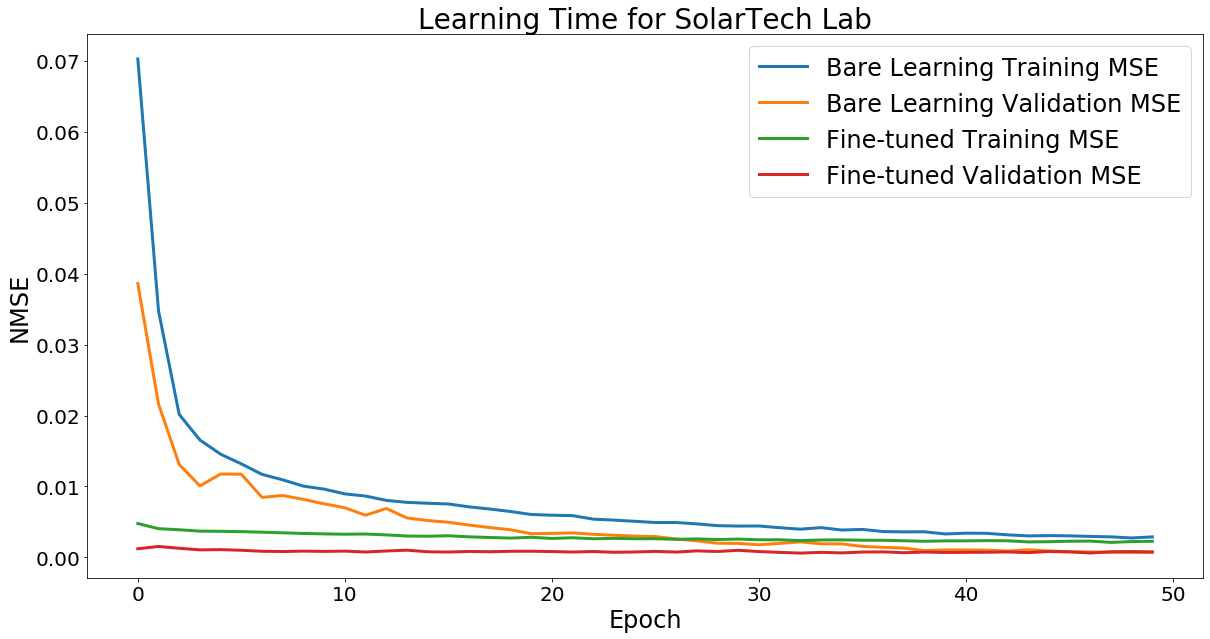

In [58]:
plt.figure(figsize=(20,10))
plt.plot(fitted_model.history['loss'],linewidth=3)
plt.plot(fitted_model.history['val_loss'],linewidth=3)
plt.plot(fitted_model_transfer.history['loss'],linewidth=3)
plt.plot(fitted_model_transfer.history['val_loss'],linewidth=3)
plt.title('Learning Time for SolarTech Lab', size='28')
plt.ylabel('NMSE', size='24')
plt.xlabel('Epoch', size='24')
plt.tick_params(axis='both', labelsize=20)
plt.legend(['Bare Learning Training MSE', 'Bare Learning Validation MSE', 'Fine-tuned Training MSE', 'Fine-tuned Validation MSE'], loc='upper right',prop={'size': 24})
plt.savefig('OperaDLTransfer_learningtime.png')

In [59]:
NMSE = fitted_model.history['val_mean_squared_error'][-1]
NMAE = fitted_model.history['val_mean_absolute_error'][-1]
NMSE_transfer = fitted_model_transfer.history['val_mean_squared_error'][-1]
NMAE_transfer = fitted_model_transfer.history['val_mean_absolute_error'][-1]

In [60]:
print(NMSE, NMAE, NMSE_transfer, NMAE_transfer)

0.000701917742844671 0.010559769347310066 0.0007741781300865114 0.01212550513446331


In [61]:
table=np.array([fitted_model.history['val_mean_squared_error'],fitted_model_transfer.history['val_mean_squared_error']])
table.transpose()

array([[0.03861581, 0.00121725],
       [0.02162122, 0.0015451 ],
       [0.01310497, 0.00128687],
       [0.01008283, 0.00106571],
       [0.0117594 , 0.00109765],
       [0.01173066, 0.00100244],
       [0.00846884, 0.00086324],
       [0.00872912, 0.00083183],
       [0.0081785 , 0.00088549],
       [0.00755658, 0.00084454],
       [0.00700025, 0.00088562],
       [0.00594625, 0.00076241],
       [0.00689689, 0.00090543],
       [0.00556085, 0.00101868],
       [0.00520223, 0.00079562],
       [0.00495533, 0.00075609],
       [0.00455851, 0.00084311],
       [0.00421018, 0.00080001],
       [0.00389532, 0.00086353],
       [0.00334021, 0.00086962],
       [0.00338912, 0.00082647],
       [0.0034582 , 0.0007573 ],
       [0.00325637, 0.00083196],
       [0.00312379, 0.00072414],
       [0.00300268, 0.00076571],
       [0.00293835, 0.00084905],
       [0.00259572, 0.00075242],
       [0.0023341 , 0.00092274],
       [0.00199949, 0.00083192],
       [0.00197512, 0.00100281],
       [0.